In [ ]:
# default_exp data.hiertsdataset

In [ ]:
#hide
from nbdev import *
%load_ext autoreload
%autoreload 2

## Hierarchical Time Series Dataset
> Receives preprocessed numpy arrays S/Y/X and S/Y/X_agg. 
> Samples entire sequences for Seq2Seq type models.

In [ ]:
# export
import numpy as np
from torch.utils.data import Dataset

In [ ]:
# hide
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')

from matplotlib import rcParams
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 22

In [ ]:
# export
class HierTimeSeriesDataset(Dataset):
    def __init__(self, 
                 # Bottom data
                 Y, X, S,
                 xcols,
                 xcols_hist,
                 xcols_futr,
                 xcols_sample_mask,
                 xcols_available_mask,
                 dates,
                 # Aggregated data
                 Y_agg, X_agg, S_agg,
                 xcols_agg,
                 xcols_hist_agg,
                 xcols_futr_agg,                 
                 # Generator parameters
                 T0, T, H,
                 lastwindow_mask=False,
                ):
        
        # Assert that raw data has correct series lens
        series_len = [len(Y_agg), len(Y), len(X_agg), len(X), len(S_agg), len(S)]
        assert len(np.unique(series_len))==1, f'Check your series length {series_len}'
        
        # Assert that raw data has correct time lens
        assert Y.shape[-1]>=T0+T and X.shape[-1]>=T0+T+H+1,\
            f'Times (Y.shape={Y.shape[-1]},T0+T={T0+T}), (X.shape={X.shape[-1]}, T0+T+H+1={T0+T+H+1})'
                
        # Bottom data
        self.Y = Y
        self.X = X
        self.S = S
        
        self.xcols      = xcols
        self.xcols_hist = xcols_hist
        self.xcols_futr = xcols_futr
        self.xcols_sample_mask = xcols_sample_mask
        self.xcols_available_mask = xcols_available_mask
        
        # Aggregated data
        self.Y_agg = Y_agg
        self.X_agg = X_agg
        self.S_agg = S_agg
        
        self.xcols_agg = xcols_agg
        self.xcols_hist_agg = xcols_hist_agg
        self.xcols_futr_agg = xcols_futr_agg        
        
        # Feature indexes 
        self.hist_agg_col    = list(xcols_agg.get_indexer(xcols_hist_agg))
        self.futr_agg_col    = list(xcols_agg.get_indexer(xcols_futr_agg))

        self.hist_col        = list(xcols.get_indexer(xcols_hist))
        self.futr_col        = list(xcols.get_indexer(xcols_futr))
        self.sample_mask_col    = xcols.get_loc(xcols_sample_mask)
        self.available_mask_col = xcols.get_loc(xcols_available_mask)
        
        self.dates = dates[T0+1:T0+T+H+1]
        
        # Copy sample mask to avoid overwriting it
        self.sample_mask = self.X[:,:,self.sample_mask_col,:].copy()
        if lastwindow_mask:
            # Create dummy to identify observations of
            # Y's last H steps (X's last H steps are forecast)
            lastwindow_mask = np.zeros(self.X[:,:,self.sample_mask_col,:].shape)
            lastwindow_mask[:,:,T0+T-H:T0+T] = 1
            self.sample_mask = lastwindow_mask
        
        # Batch parameters
        self.T0   = T0
        self.T    = T
        self.H    = H
        
    def __len__(self):
        return len(self.Y_agg) 
    
    def __getitem__(self, idx):
        # Parse time indexes
        T0 = self.T0
        T  = self.T
        H  = self.H
        
        # [G,N,C,T]
        s = self.S[idx,:,:]
        x = self.X[idx,:,:,T0:T0+T][:,self.hist_col,:]
        f = self.X[idx,:,:,T0+1:T0+T+H+1][:,self.futr_col,:]
        y = self.Y[idx,:,T0+1:T0+T]
        
        sample_mask    = self.sample_mask[idx,:,T0+1:T0+T]
        available_mask = self.X[idx,:,:,T0+1:T0+T][:,self.available_mask_col,:]
        
        # [G,C,T] Shared features across N
        s_agg    = self.S_agg[idx,:]
        x_agg    = self.X_agg[idx,:,T0:T0+T,][self.hist_agg_col,:]
        f_agg    = self.X_agg[idx,:,T0+1:T0+T+H+1][self.futr_agg_col,:]
        y_agg    = self.Y_agg[idx,:,T0+1:T0+T]

        batch = dict(# Bottom data
                     Y=y, S=s, X=x, F=f,
                     sample_mask=sample_mask,
                     available_mask=available_mask,
                     # Aggregated data
                     Y_agg=y_agg, S_agg=s_agg, X_agg=x_agg, F_agg=f_agg)
            
        #print('\n')
        #print('================== BATCH ==============')
        #for key in batch.keys():
        #    print(f'{key}.shape:\t{batch[key].shape}')
        #print('\n')
        return batch

<a name="cell-2"></a>
## 2. HierTimeseriesDataset Validation

In [ ]:
from torch.utils.data import DataLoader
from neuralforecast.data.datasets.tourismL import TourismL

directory = './data/hierarchical/TourismL'
TourismL.preprocess_data(directory=directory, verbose=False)
data = TourismL.load_process(directory=directory, verbose=False)

In [ ]:
T = 228-12-12
H = 12

train_dataset = HierTimeSeriesDataset(# Bottom data
                                      X=data['X'], 
                                      S=data['S'], 
                                      Y=data['Y'],
                                      xcols=data['xcols'],
                                      xcols_hist=data['xcols_hist'],
                                      xcols_futr=data['xcols_futr'],
                                      xcols_sample_mask=data['xcols_sample_mask'],
                                      xcols_available_mask=data['xcols_available_mask'],
                                      dates = data['dates'],
                                      # Aggregated data
                                      X_agg=data['X_agg'], 
                                      S_agg=data['S_agg'], 
                                      Y_agg=data['Y_agg'],
                                      xcols_agg=data['xcols_agg'],
                                      xcols_hist_agg=data['xcols_hist_agg'],
                                      xcols_futr_agg=data['xcols_futr_agg'],
                                      # Generator parameters
                                      T0=0,T=T,H=H)

valid_dataset = HierTimeSeriesDataset(# Bottom data
                                      X=data['X'], 
                                      S=data['S'], 
                                      Y=data['Y'],
                                      xcols=data['xcols'],
                                      xcols_hist=data['xcols_hist'],
                                      xcols_futr=data['xcols_futr'],
                                      xcols_sample_mask=data['xcols_sample_mask'],
                                      xcols_available_mask=data['xcols_available_mask'], 
                                      dates = data['dates'],
                                      # Aggregated data
                                      X_agg=data['X_agg'], 
                                      S_agg=data['S_agg'], 
                                      Y_agg=data['Y_agg'],
                                      xcols_agg=data['xcols_agg'],
                                      xcols_hist_agg=data['xcols_hist_agg'],
                                      xcols_futr_agg=data['xcols_futr_agg'],
                                      # Generator parameters
                                      T0=24,T=T,H=H,
                                      lastwindow_mask=True)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))

for key in train_batch.keys():
    print(f'{key}.shape', train_batch[key].shape)

Y.shape torch.Size([4, 4, 203])
S.shape torch.Size([4, 4, 4])
X.shape torch.Size([4, 4, 1, 204])
F.shape torch.Size([4, 4, 3, 216])
sample_mask.shape torch.Size([4, 4, 203])
available_mask.shape torch.Size([4, 4, 203])
Y_agg.shape torch.Size([4, 4, 203])
S_agg.shape torch.Size([4, 35])
X_agg.shape torch.Size([4, 4, 204])
F_agg.shape torch.Size([4, 1, 216])


### 5.1 Examinate HierTimeSeriesDataset aggregate batch
1. Examinate the hierarchically linked Y_agg series.
2. Examinate the alignment between Y_agg and X_agg_futr.
3. Validate the S_agg dummies generated from H constraints matrix.

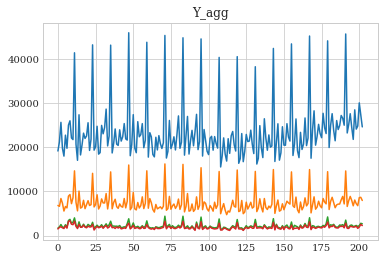

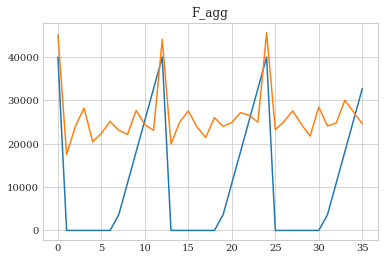

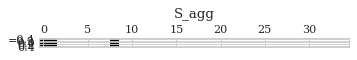

In [ ]:
# Parse batch and filter for first entry
batch = valid_batch
S_agg = batch['S_agg'][0]
Y_agg = batch['Y_agg'][0]
X_agg = batch['X_agg'][0]
F_agg = batch['F_agg'][0]

#---------------- Hierarchical Y_agg ----------------#
plt.plot(Y_agg[0,:])
plt.plot(Y_agg[1,:])
plt.plot(Y_agg[2,:])
plt.plot(Y_agg[3,:])
plt.title('Y_agg')
plt.show()
plt.close()

#---------------- X_agg_futr ----------------#
F_agg = np.maximum(F_agg[0,:]*80000,
                   np.zeros(F_agg[0,:].shape))
plt.plot(F_agg[-36:])
plt.plot(Y_agg[0,-36:])
plt.title('F_agg')
plt.show()
plt.close()

#---------------- S_agg ----------------#
plt.figure(num=1, figsize=(5, 5), dpi=80, facecolor='w')
plt.spy(S_agg[None,:])
plt.title('S_agg')
plt.show()
plt.close()

### 5.2 Examinate HierTimeSeriesDataset bottom batch
1. Examinate the alignment between Y_bottom, S_bottom and X_bottom_futr.
2. Validate batch Seq2Seq structure between X_bottom vs Y_bottom.

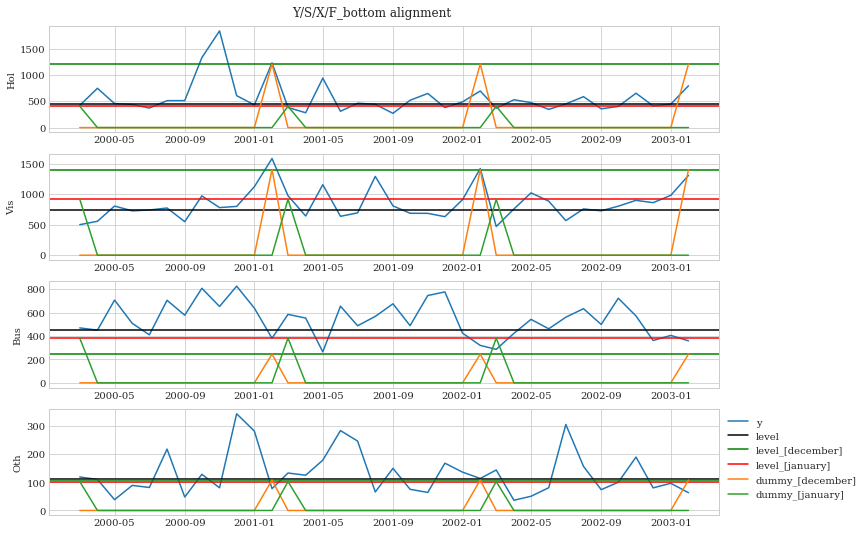

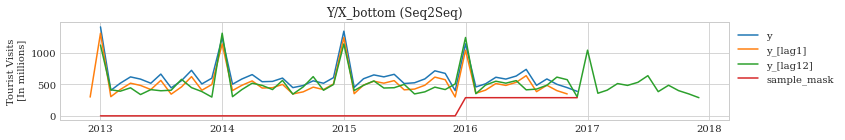

In [ ]:
# Parse batch and filter for first entry
# batch = train_batch
# dates = train_dataset.dates
batch    = valid_batch
dates    = valid_dataset.dates
S_bottom = batch['S'][0]
Y_bottom = batch['Y'][0]
X_bottom = batch['X'][0]
F_bottom = batch['F'][0]
sample_mask = batch['sample_mask'][0]

#---------------- Y/S/X_bottom alignment ----------------#
n_years = 3
fig, axs = plt.subplots(4,1, figsize=(12, 9))

for idx, purpose in enumerate(['Hol', 'Vis', 'Bus', 'Oth']):    
    axs[idx].plot(dates[1:n_years*12+1],Y_bottom[idx,:n_years*12], label='y')
    axs[idx].axhline(y=S_bottom[idx,0],
                label='level', color='black')
    axs[idx].axhline(y=S_bottom[idx,0]*S_bottom[idx,2], 
                label='level_[december]', color='green')
    axs[idx].axhline(y=S_bottom[idx,0]*S_bottom[idx,3],
                label='level_[january]', color='red')
    
    axs[idx].plot(dates[1:n_years*12+1],
                  F_bottom[idx,0,:n_years*12]*S_bottom[idx,0]*S_bottom[idx,2],
                 label='dummy_[december]')
    axs[idx].plot(dates[1:n_years*12+1],
                  F_bottom[idx,1,:n_years*12]*S_bottom[idx,0]*S_bottom[idx,3],
                 label='dummy_[january]')
    axs[idx].set_ylabel(purpose)

plt.suptitle('Y/S/X/F_bottom alignment ', y=0.91)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()
plt.close()

#---------------- Y/X_bottom Seq2Seq structure ----------------#
idx = 0
start = 155
end = 203
print('\n')
plt.figure(figsize=(12, 1.8))
plt.plot(dates[start:end],     Y_bottom[idx,start:end]+100, label='y')
plt.plot(dates[start-1:end-1], X_bottom[idx,0,start:end], label='y_[lag1]')
plt.plot(dates[start:end+12],  F_bottom[idx,2,start:end+12], label='y_[lag12]')
plt.plot(dates[start:end],     sample_mask[idx,start:end]*Y_bottom[idx,-1], label='sample_mask')
plt.ylabel('Tourist Visits\n [In millions]')
plt.title('Y/X_bottom (Seq2Seq)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()
plt.close()